In [1]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, StringType

import wrangle as w

In [2]:
df = w.wrangle_311()
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/23 15:10:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



df shape: (841704, 20)



In [3]:
df.show(1, vertical = True)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  el paso st,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 1603                 
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
only showing top 1 row



In [4]:
df.groupby("case_status").count().show()

+-----------+------+
|case_status| count|
+-----------+------+
|       Open| 18110|
|     Closed|823594|
+-----------+------+



In [5]:
df.groupby("case_status").agg(mean("case_lifetime")).show()

+-----------+------------------+
|case_status|avg(case_lifetime)|
+-----------+------------------+
|       Open|1466.8733848702375|
|     Closed| 9.108263294778737|
+-----------+------------------+



Text(0.5, 0, 'Number of Cases')

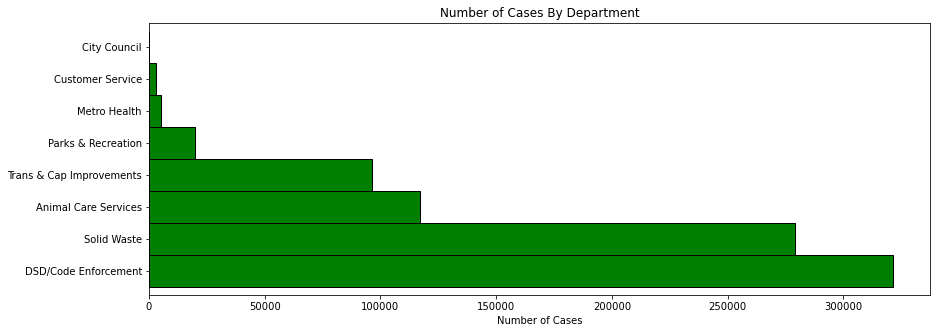

In [6]:
# First aggregate with spark
(
    df.groupBy("department")
    .count()
    # then pass to pandas
    .toPandas()
    .set_index("department")["count"]
    .sort_values(ascending=False)
    .plot.barh(width=1, edgecolor="black", color='green', figsize=(14, 5))
)

plt.title("Number of Cases By Department")
plt.ylabel("")
plt.xlabel("Number of Cases")

Text(0.5, 1.0, 'Case Lifetime By Department')

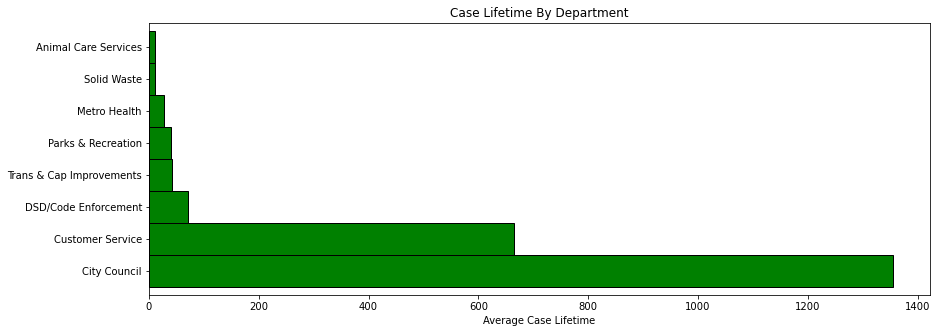

In [7]:
# first aggregate with spark
(
    df.groupBy("department")
    .agg(mean("case_lifetime").alias("avg_case_lifetime"))
    # then pass the data to pandas for visualization
    .toPandas()
    .set_index("department")
    .avg_case_lifetime.sort_values(ascending=False)
    .plot.barh(width=1, edgecolor="black", color='green', figsize=(14, 5))
)

plt.xlabel("Average Case Lifetime")
plt.ylabel("")
plt.title("Case Lifetime By Department")

In [8]:
(
    df.groupBy("department")
    .pivot("case_status")
    .agg(round(mean("case_lifetime"), 2))
    .orderBy("Closed")
    .show(truncate=False)
)

+------------------------+------+-------+
|department              |Closed|Open   |
+------------------------+------+-------+
|Solid Waste             |3.4   |1400.45|
|Animal Care Services    |5.51  |1405.36|
|Metro Health            |6.82  |1388.64|
|Trans & Cap Improvements|8.0   |1438.39|
|Parks & Recreation      |10.66 |1448.72|
|DSD/Code Enforcement    |15.64 |1475.56|
|City Council            |29.25 |1538.07|
|Customer Service        |48.94 |1556.94|
+------------------------+------+-------+



In [9]:
sample = df.sample(fraction=0.01, seed=13).toPandas()
print("shape:", sample.shape)
sample.head()

shape: (8522, 20)


,case_id,case_opened_date,case_closed_date,case_due_date,case_late,num_days_late,case_closed,service_request_type,SLA_days,case_status,source_id,request_address,council_district,num_weeks_late,zipcode,case_age,days_to_closed,case_lifetime,department,dept_subject_to_SLA
0,1014127339,2018-01-01 06:58:00,2018-01-02 15:32:00,2018-01-17 08:30:00,False,-14.706620,True,Front Or Side Yard Parking,16.063796,Closed,svcCRMSS,"10133 figaro canyon, san antonio, 78251",004,-2.100946,78251,1603,1.0,1,DSD/Code Enforcement,True
1,1014127368,2018-01-01 07:18:00,2018-01-02 15:22:00,2018-01-17 08:30:00,False,-14.713275,True,Right Of Way/Sidewalk Obstruction,16.049769,Closed,svcCRMSS,"10133 figaro canyon, san antonio, 78251",004,-2.101896,78251,1603,1.0,1,DSD/Code Enforcement,True
2,1014127446,2018-01-01 11:27:00,2018-01-03 17:08:00,2018-01-06 11:27:00,False,-2.763333,True,Aggressive Animal(Non-Critical),5.000000,Closed,139344,san fernando and san horacio s,005,-0.394762,,1603,2.0,2,Animal Care Services,True
3,1014127470,2018-01-01 12:33:00,2018-01-01 12:43:00,2020-09-26 12:33:00,False,-998.993079,True,Stray Animal,999.000000,Closed,139344,"159 surfrider, san antonio, 78242",004,-142.713297,78242,1603,0.0,0,Animal Care Services,True
4,1014127599,2018-01-01 15:25:00,2018-01-03 05:52:00,2018-01-02 03:25:00,True,1.101817,True,Trapped/Confined Animal,0.500000,Closed,rs16746,"633 st marys s, san antonio, 78205",001,0.157402,78205,1603,2.0,2,Animal Care Services,True


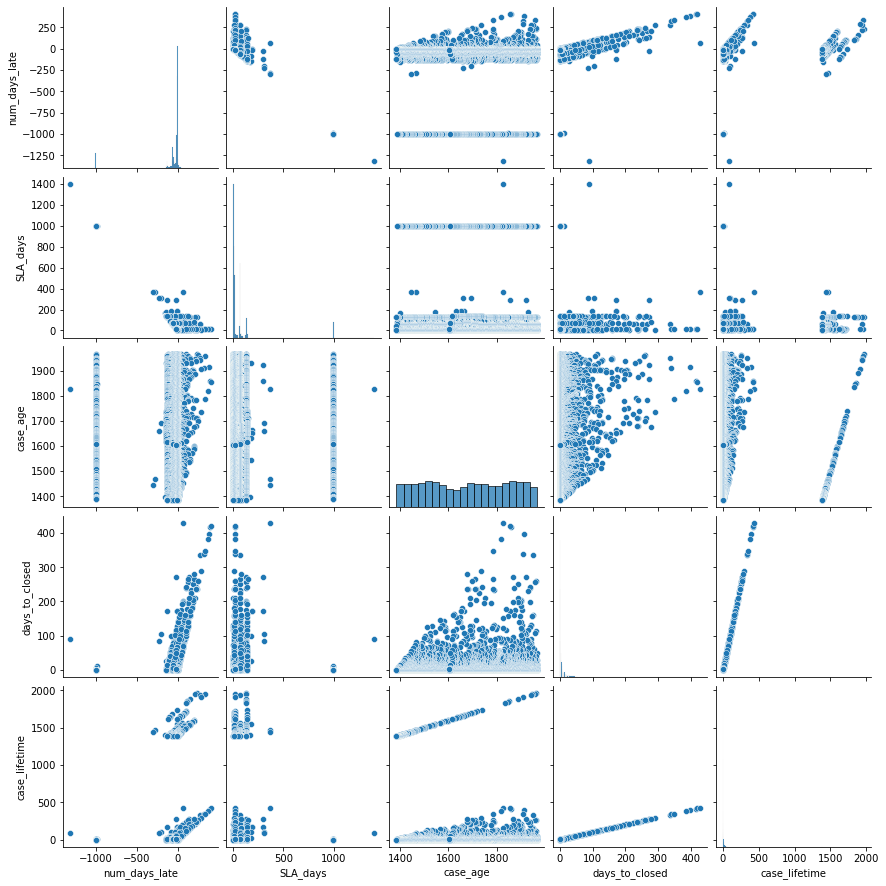

In [10]:
numeric_cols = [
    "num_days_late",
    "SLA_days",
    "case_age",
    "days_to_closed",
    "case_lifetime",
]

sns.pairplot(sample[numeric_cols])

<AxesSubplot:ylabel='Frequency'>

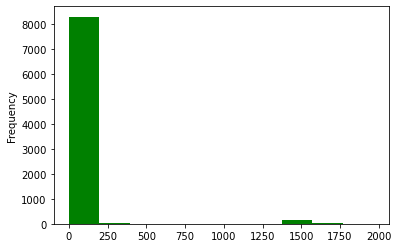

In [11]:
sample.case_lifetime.plot.hist(color='green')

In [12]:
pd.cut(sample.case_lifetime, 4).value_counts().sort_index()

(-1.965, 491.25]     8326
(491.25, 982.5]         0
(982.5, 1473.75]      143
(1473.75, 1965.0]      53
Name: case_lifetime, dtype: int64

[0, 1)        2533
[1, 2)        1630
[2, 5)        1437
[5, 15)       1415
[15, 1000)    1311
Name: case_lifetime, dtype: int64


Text(0.5, 1.0, 'Overall Case Lifetime')

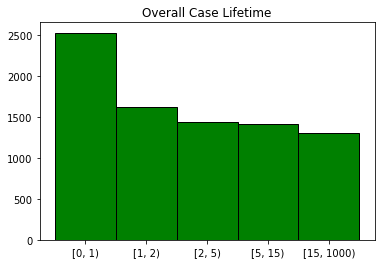

In [13]:
# In the call to `pd.cut`, we add right=False so that the behavior of pd.cut
# aligns with the behavior of np.histogram, which is what matplotlib uses when
# constructing a histogram.

# custom bins of varying widths
bins = [0, 1, 2, 5, 15, 1000]

print(
    pd.cut(sample.case_lifetime, bins, right=False).value_counts().sort_index()
)

pd.cut(
    sample.case_lifetime, bins, right=False
).value_counts().sort_index().plot.bar(
    width=1, edgecolor="black", color="green"
)
plt.xticks(rotation=0)
plt.title("Overall Case Lifetime")

In [14]:
closed_cases = sample.query("case_closed")
open_cases = sample.query("not case_closed")

Text(0.5, 0.98, 'Distribution of Case Lifetime')

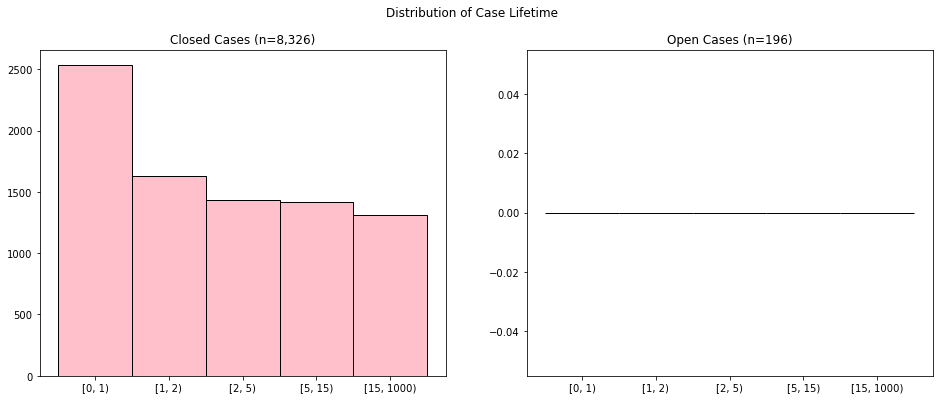

In [15]:
plt.figure(figsize=(16, 6))

plt.subplot(121)
(
    pd.cut(closed_cases.case_lifetime, bins=bins, right=False)
    .value_counts()
    .sort_index()
    .plot.bar(width=1, edgecolor="black", color="pink", ax=plt.gca())
)
plt.title("Closed Cases (n={:,})".format(closed_cases.shape[0]))
plt.xticks(rotation=0)

plt.subplot(122)
(
    pd.cut(open_cases.case_lifetime, bins=bins, right=False)
    .value_counts()
    .sort_index()
    .plot.bar(width=1, edgecolor="black", color="pink", ax=plt.gca())
)
plt.title("Open Cases (n={:,})".format(open_cases.shape[0]))
plt.xticks(rotation=0)

plt.suptitle("Distribution of Case Lifetime")

In [16]:
cases_by_day = df.select(
    "department",
    date_format("case_opened_date", "yyyy-MM-dd").alias("case_opened_date"),
    date_format("case_closed_date", "yyyy-MM-dd").alias("case_closed_date"),
)

cases_by_day.show(5)

+--------------------+----------------+----------------+
|          department|case_opened_date|case_closed_date|
+--------------------+----------------+----------------+
|Animal Care Services|      2018-01-01|      2018-01-01|
|Trans & Cap Impro...|      2018-01-01|      2018-01-03|
|Trans & Cap Impro...|      2018-01-01|      2018-01-02|
|DSD/Code Enforcement|      2018-01-01|      2018-01-02|
|Animal Care Services|      2018-01-01|      2018-01-01|
+--------------------+----------------+----------------+
only showing top 5 rows



In [17]:
cases_opened_by_day = (
    cases_by_day
    .groupby('case_opened_date')
    .count()
    .na.drop()
    .sort('case_opened_date')
    .toPandas()
    .assign(case_opened_date=lambda df: pd.to_datetime(df.case_opened_date))
    .set_index('case_opened_date')
    ['count']
)
cases_opened_by_day.name = 'cases_opened'

In [18]:
cases_closed_by_day = (
    cases_by_day
    .groupby('case_closed_date')
    .count()
    .na.drop()
    .sort('case_closed_date')
    .toPandas()
    .assign(case_closed_date=lambda df: pd.to_datetime(df.case_closed_date))
    .set_index('case_closed_date')
    ['count']
)
cases_closed_by_day.name = 'cases_closed'

In [19]:
ts = pd.concat([cases_opened_by_day, cases_closed_by_day], axis=1)
ts.head(5)

,cases_opened,cases_closed
2017-01-01,155,67
2017-01-02,1397,385
2017-01-03,1760,734
2017-01-04,1613,1206
2017-01-05,1791,1173


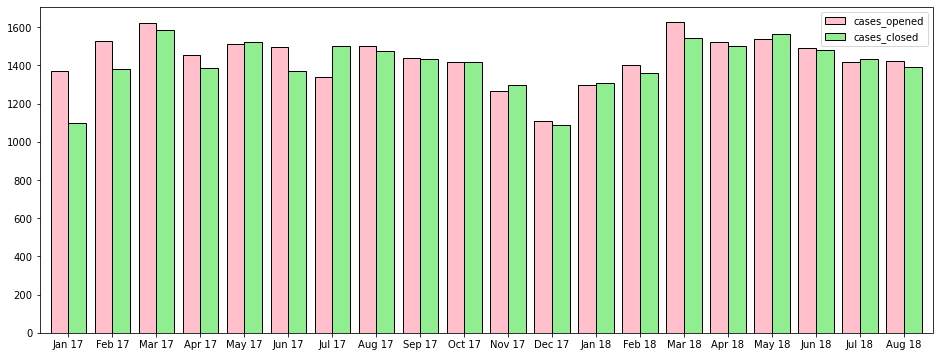

In [20]:
ts.resample("M").mean().plot.bar(
    figsize=(16, 6), width=0.8, ec="black", color=["pink", "lightgreen"]
)

# pretty x-axis labels
ticks, labels = plt.xticks()
labels = pd.to_datetime([l.get_text() for l in labels]).strftime("%b %y")
plt.xticks(ticks, labels, rotation=0)
None

### How many different cases are there, by department?

Text(0.5, 1.0, 'Number of Cases By Department')

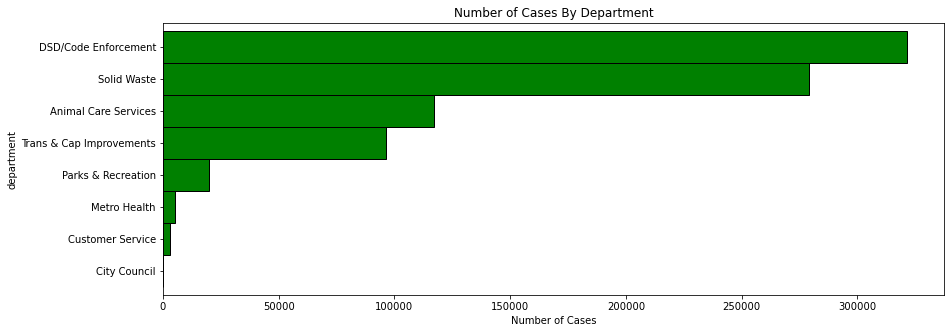

In [21]:
(
    df.groupby("department")
    .count()
    .toPandas()
    .set_index("department")["count"]
    .sort_values()
    .plot.barh(width=1, edgecolor="black", color='green', figsize=(14, 5))
)
plt.xlabel("Number of Cases")
plt.title("Number of Cases By Department")

### Does the percentage of cases that are late vary by department?

In [22]:
df.dtypes

[('case_id', 'int'),
 ('case_opened_date', 'timestamp'),
 ('case_closed_date', 'timestamp'),
 ('case_due_date', 'timestamp'),
 ('case_late', 'boolean'),
 ('num_days_late', 'double'),
 ('case_closed', 'boolean'),
 ('service_request_type', 'string'),
 ('SLA_days', 'double'),
 ('case_status', 'string'),
 ('source_id', 'string'),
 ('request_address', 'string'),
 ('council_district', 'string'),
 ('num_weeks_late', 'double'),
 ('zipcode', 'string'),
 ('case_age', 'int'),
 ('days_to_closed', 'int'),
 ('case_lifetime', 'int'),
 ('department', 'string'),
 ('dept_subject_to_SLA', 'boolean')]

Text(0.5, 1.0, '% of Late Cases By Department')

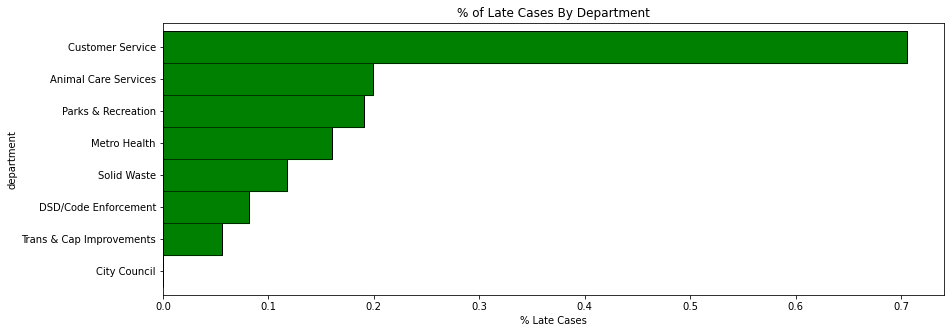

In [23]:
(
    df.withColumn("case_late", col("case_late").cast("int"))
    .groupby("department")
    .agg(avg("case_late").alias("prob_cases_late"))
    .toPandas()
    .set_index("department")
    .prob_cases_late.sort_values()
    .plot.barh(width=1, edgecolor="black", color='green', figsize=(14, 5))
)
plt.xlabel("% Late Cases")
plt.title("% of Late Cases By Department")

### On average, how late are the late cases by department?

Text(0.5, 1.0, 'Avg Number of Days Late By Department')

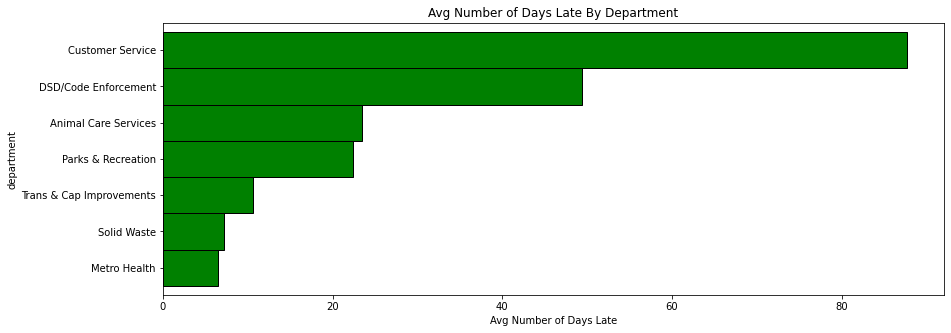

In [24]:
(
    df.where('case_late')
    .groupby("department")
    .agg(avg("num_days_late").alias("days_cases_late"))
    .toPandas()
    .set_index("department")
    .days_cases_late.sort_values()
    .plot.barh(width=1, edgecolor="black", color='green', figsize=(14, 5))
)
plt.xlabel("Avg Number of Days Late")
plt.title("Avg Number of Days Late By Department")

### What is the service type that is the most late? Just for Parks & Rec?

Text(0.5, 1.0, 'Avg Number of Days Late By Department')

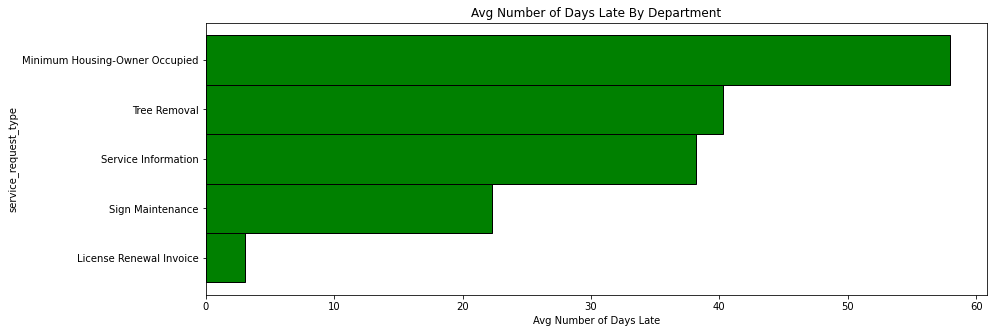

In [25]:
(
    df.where('case_late')
    .groupby("service_request_type")
    .agg(avg("num_days_late").alias("days_cases_late"))
    .limit(5)
    .toPandas()
    .set_index("service_request_type")
    .days_cases_late.sort_values()
    .plot.barh(width=1, edgecolor="black", color='green', figsize=(14, 5))
)
plt.xlabel("Avg Number of Days Late")
plt.title("Avg Number of Days Late By Department")

Text(0.5, 1.0, 'Avg Number of Days Late By Department')

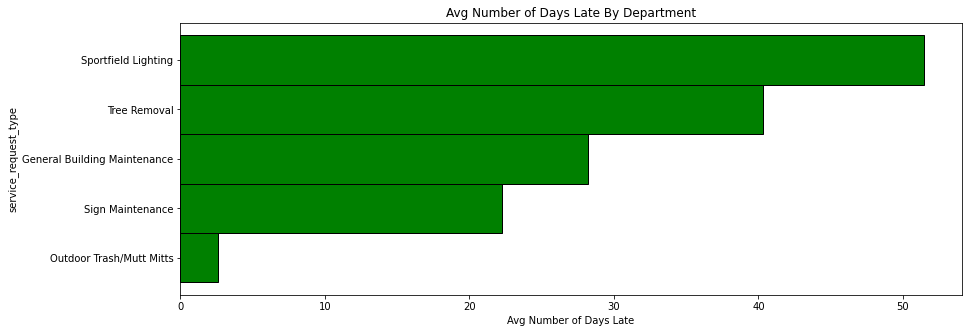

In [26]:
(
    df.where('case_late').where(df.department=='Parks & Recreation')
    .groupby("service_request_type")
    .agg(avg("num_days_late").alias("days_cases_late"))
    .limit(5)
    .toPandas()
    .set_index("service_request_type")
    .days_cases_late.sort_values()
    .plot.barh(width=1, edgecolor="black", color='green', figsize=(14, 5))
)
plt.xlabel("Avg Number of Days Late")
plt.title("Avg Number of Days Late By Department")

### For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

Text(0.5, 1.0, 'Requests in DSD/Code Enforcement')

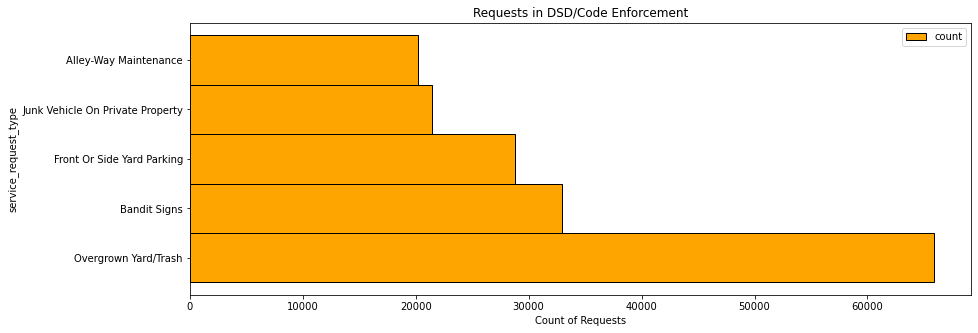

In [27]:
(
    df.where(expr('department=="DSD/Code Enforcement"'))
    .groupby("service_request_type")
    .count()
    .sort(desc('count'))
    .limit(5)
    .toPandas()
    .set_index("service_request_type")
    .plot.barh(width=1, edgecolor="black", color='orange', figsize=(14, 5))
)
plt.xlabel("Count of Requests")
plt.title("Requests in DSD/Code Enforcement")

Text(0.5, 1.0, 'Requests in Parks & Recreation')

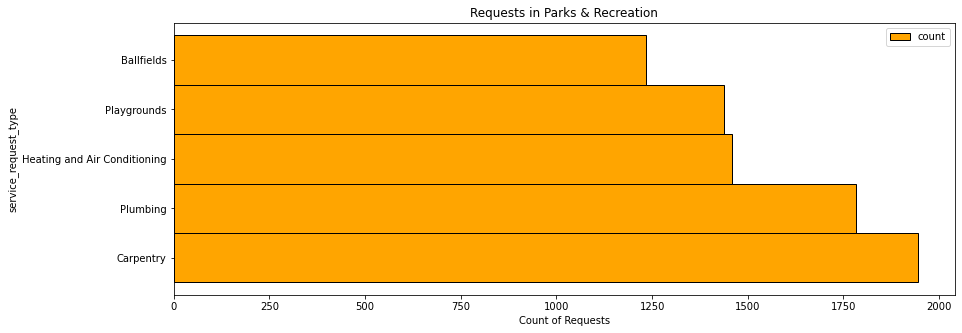

In [28]:
(
    df.where(expr('department=="Parks & Recreation"'))
    .groupby("service_request_type")
    .count()
    .sort(desc('count'))
    .limit(5)
    .toPandas()
    .set_index("service_request_type")
    .plot.barh(width=1, edgecolor="black", color='orange', figsize=(14, 5))
)
plt.xlabel("Count of Requests")
plt.title("Requests in Parks & Recreation")

Text(0.5, 1.0, 'Requests in Animal Care Services')

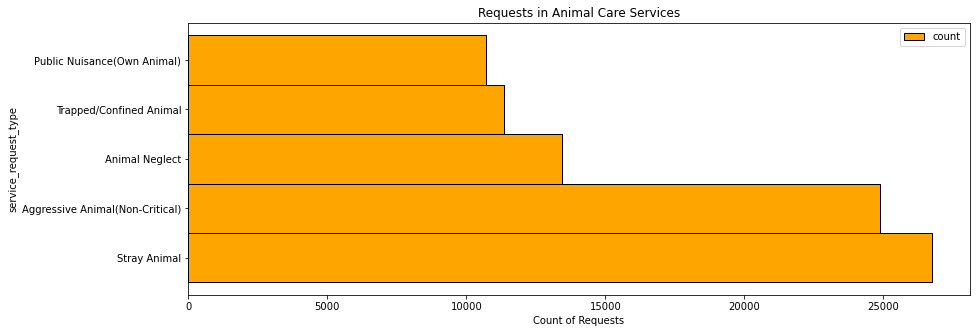

In [29]:
(
    df.where(expr('department=="Animal Care Services"'))
    .groupby("service_request_type")
    .count()
    .sort(desc('count'))
    .limit(5)
    .toPandas()
    .set_index("service_request_type")
    .plot.barh(width=1, edgecolor="black", color='orange', figsize=(14, 5))
)
plt.xlabel("Count of Requests")
plt.title("Requests in Animal Care Services")

### Does whether or not its a weekend matter for when a case is opened/closed?

In [30]:
df = df.withColumn("week_day_name", date_format("case_opened_date", "E"))

In [31]:
df.show(1, vertical=True)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  el paso st,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 1603                 
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
 week_day_name        | Mon       

Text(0.5, 1.0, 'Cases Opened by Weekday')

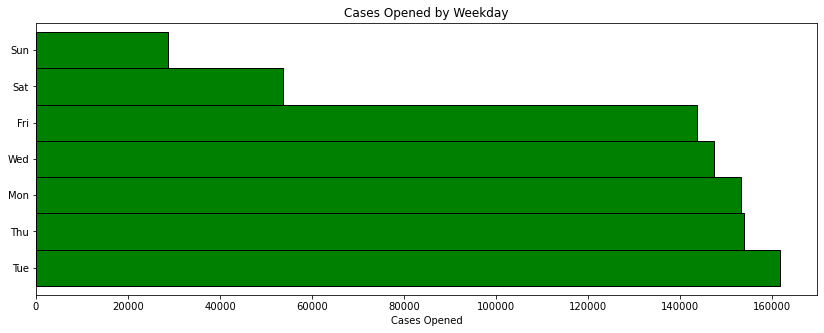

In [32]:
#cases opened
(
    df.groupBy("week_day_name")
    .count()
    .sort(desc('count'))
    # then pass the data to pandas for visualization
    .toPandas()
    .set_index("week_day_name")["count"]
    .plot.barh(width=1, edgecolor="black", color='green', figsize=(14, 5))
)

plt.xlabel("Cases Opened")
plt.ylabel("")
plt.title("Cases Opened by Weekday")

In [33]:
#case closed
df = df.withColumn("week_day_name_closed", date_format("case_closed_date", "E"))

Text(0.5, 1.0, 'Cases Closed by Weekday')

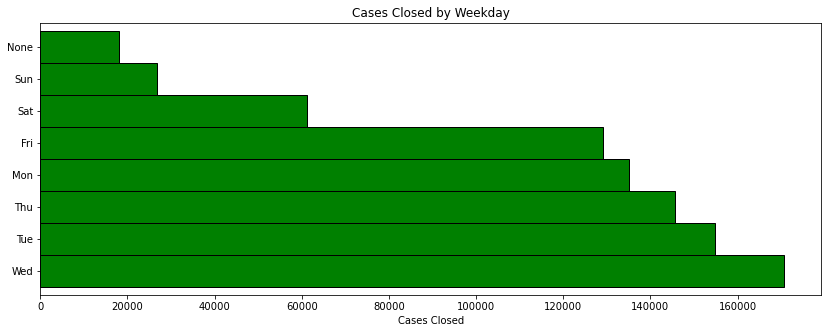

In [34]:
#day of the week case was closed
(
    df.groupBy("week_day_name_closed")
    .count()
    .sort(desc('count'))
    # then pass the data to pandas for visualization
    .toPandas()
    .set_index("week_day_name_closed")["count"]
    .plot.barh(width=1, edgecolor="black", color='green', figsize=(14, 5))
)

plt.xlabel("Cases Closed")
plt.ylabel("")
plt.title("Cases Closed by Weekday")

Seems that less cases are opened and closed on Saturdays and Sundays.

### On average, how many cases are opened a day for the Customer Service department?

In [35]:
n_cases = (
    df.withColumn("case_opened_date", expr("date(case_opened_date)"))
    .filter(df.department == "Customer Service")
    .groupby("case_opened_date")
    .count()
    .toPandas()
)


In [36]:
n_cases

,case_opened_date,count
0,2018-03-17,2
1,2018-01-23,9
2,2018-02-26,4
3,2018-01-11,8
4,2018-01-08,1
...,...,...
507,2017-11-24,2
508,2017-12-27,6
509,2017-10-25,6
510,2017-11-27,9


In [37]:
#5.56 cases opened on average
n_cases.mean()

count    5.564453
dtype: float64

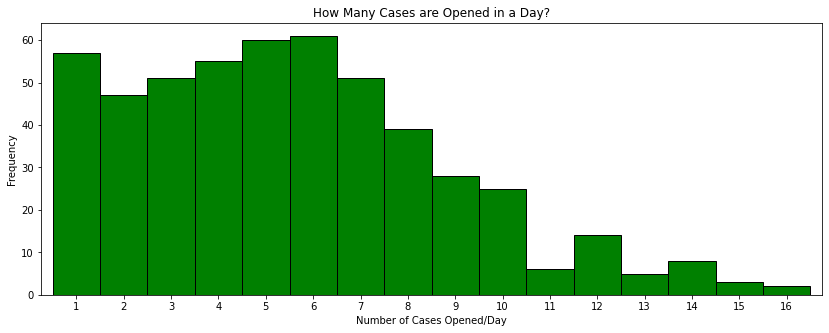

In [38]:
n_of_cases = n_cases['count']
mean_cases = n_of_cases.mean()
n_of_cases.value_counts().sort_index().plot.bar(width=1, edgecolor="black", color='green', figsize=(14, 5))
plt.xlabel("Number of Cases Opened/Day")
plt.ylabel("Frequency")
plt.title("How Many Cases are Opened in a Day?")
plt.xticks(rotation=0)
plt.show()

### Does the number of service requests for the solid waste department vary by day of the week?

In [39]:
n_cases = (
    df.withColumn("case_opened_date", expr("date(case_opened_date)"))
    .filter(df.department == "Solid Waste")
    .groupby('case_opened_date')
    .count()
    #.toPandas()
)



In [40]:
n_cases = n_cases.withColumn("week_day_name", date_format("case_opened_date", "E"))

In [41]:
n_cases = n_cases.toPandas().set_index('week_day_name')

In [42]:
n_cases

,case_opened_date,count
week_day_name,,
Sat,2018-03-17,213
Tue,2018-01-23,574
Mon,2018-02-26,735
Thu,2018-01-11,538
Mon,2018-01-08,696
...,...,...
Wed,2017-12-27,391
Thu,2017-11-23,22
Wed,2017-10-25,373


In [43]:
n_cases = n_cases.drop(columns=['case_opened_date'])

In [44]:
n_cases = n_cases.groupby(['week_day_name']).mean()

In [45]:
n_cases

,count
week_day_name,
Fri,616.903614
Mon,691.488095
Sat,184.481928
Sun,81.964286
Thu,574.915663
Tue,691.904762
Wed,499.369048


<AxesSubplot:xlabel='week_day_name'>

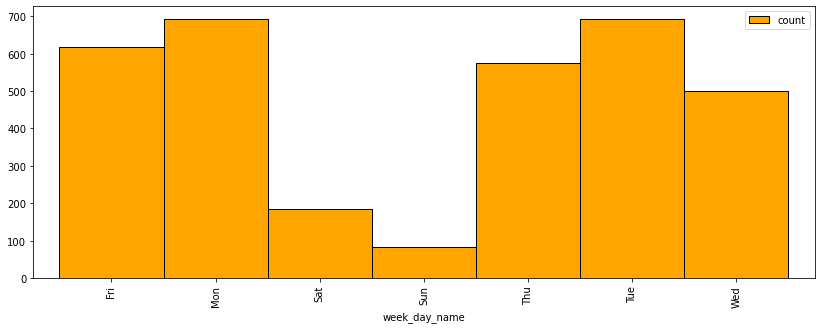

In [46]:
n_cases.plot.bar(width=1, edgecolor="black", color='orange', figsize=(14, 5))

They seem pretty consistent over the weekdays, but drop during the weekends.

In [47]:
days = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
#days_type = pd.Categorical(n_cases['week_day_name'],categories=days, ordered=True)

#n_cases['week_day_name'] = n_cases['week_day_name'].astype('category')

In [48]:
n_cases = n_cases.reset_index()

In [49]:
n_cases.loc[n_cases['week_day_name']=='Mon', 'order']=1
n_cases.loc[n_cases['week_day_name']=='Tue', 'order']=2
n_cases.loc[n_cases['week_day_name']=='Wed', 'order']=3
n_cases.loc[n_cases['week_day_name']=='Thu', 'order']=4
n_cases.loc[n_cases['week_day_name']=='Fri', 'order']=5
n_cases.loc[n_cases['week_day_name']=='Sat', 'order']=6
n_cases.loc[n_cases['week_day_name']=='Sun', 'order']=7

In [50]:
n_cases

,week_day_name,count,order
0,Fri,616.903614,5.0
1,Mon,691.488095,1.0
2,Sat,184.481928,6.0
3,Sun,81.964286,7.0
4,Thu,574.915663,4.0
5,Tue,691.904762,2.0
6,Wed,499.369048,3.0


In [51]:
n_cases = n_cases.sort_values('order')

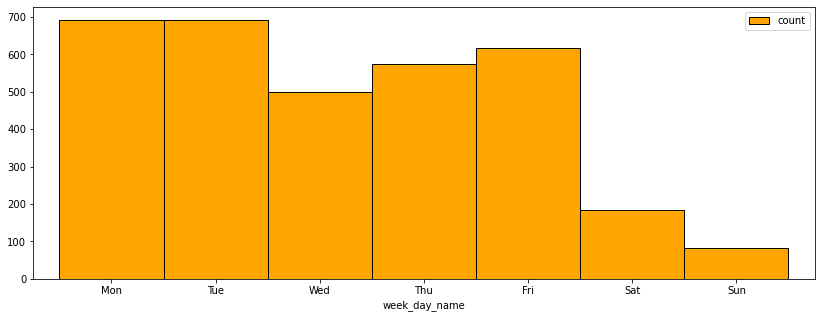

In [52]:
n_cases.plot.bar(x = 'week_day_name', y='count',width=1, edgecolor="black", color='orange', figsize=(14, 5))
plt.xticks(rotation=0)
plt.show()

In [53]:
n_cases = (
    df.withColumn("case_opened_date", expr("date(case_opened_date)"))
    .filter(df.department == "Solid Waste")
    .groupby('case_opened_date')
    .count()
    .set_index
)




AttributeError: 'DataFrame' object has no attribute 'set_index'